# Exploration des données textuelles (titres et/ou résumés)

Ce notebook explore les données textuelles des résumés et titres de notices bibliographiques afin de voir si des patterns se dégagent rapidement

# Set project

### Packages

In [16]:
# Import librairies
import os
import re
import pandas as pd
import nltk
import numpy as np
import pyLDAvis
#import pyLDAvis.sklearn
import seaborn as sns
import spacy
import warnings

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

from utils_text_processing import *
from utils_visualization import *

In [17]:
# Suppression des FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

### Graphical parameters

In [18]:
# Parametres graphiques
%matplotlib inline
rc = {
    'font.size': 14,
    'font.family': 'Arial',
    'axes.labelsize': 14,
    'legend.fontsize': 12,
    'axes.titlesize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'figure.max_open_warning': 30}

sns.set(font='Arial', rc=rc)
sns.set_style(
    "whitegrid", {
        'axes.edgecolor': 'k',
        'axes.linewidth': 1,
        'axes.grid': False,
        'xtick.major.width': 1,
        'ytick.major.width': 1
        })
sns.set_context(
    "talk",
    font_scale=1.1,
    rc={"lines.linewidth": 1.5})
pd.set_option('display.max_columns', None)


In [19]:
# Autorisation pour la visualisation par pyLDAvis
pyLDAvis.enable_notebook()

### Paths

In [20]:
# Set paths
path = "."
os.chdir(path)
data_path = path + "/data"
output_path = path + "/outputs"
fig_path = path + "/figs"

### Useful functions

# Import data

In [21]:
# Input data
working_data_filename = "working_data_sans_dewey.pkl"
rameau_file = "rameau_Tf_Td.csv"
analyse_dewey = False

In [22]:
# Import data
df = pd.read_pickle(os.path.join(data_path, working_data_filename))
print(f"le Fichier de données contient {df.shape[0]} lignes et  {df.shape[1]} colonnes")

le Fichier de données contient 154508 lignes et  10 colonnes


In [23]:
# Visualisation
df.head()

,PPN,TITRE,RESUME,RAMEAU,DEWEY,DESCR,RAMEAU_CHECKED,presence_chaine_indexation,rameau_chaines_index,rameau_concepts
0,000002364,La culture pour vivre,Mort de la culture populaire en France. Mutati...,Culture populaire;Diffusion de la culture;Poli...,840,La culture pour vivre Mort de la culture popul...,Culture populaire;Diffusion de la culture;Poli...,False,"[Culture populaire, Diffusion de la culture, P...","[Culture populaire, Diffusion de la culture, P..."
1,000014877,"La nuit, le jour : essai psychanalytique sur l...","Discontinuité, latence, rétablissement d’une c...",Complexe de castration;Psychanalyse;Rêves,154.63,"La nuit, le jour : essai psychanalytique sur l...",Complexe de castration;Psychanalyse;Rêves,False,"[Complexe de castration, Psychanalyse, Rêves]","[Complexe de castration, Psychanalyse, Rêves]"
2,000021857,"Ruptures, cultures","Il faut imaginer Robinson sur son île, au mome...",Culture,840,"Ruptures, cultures Il faut imaginer Robinson s...",Culture,False,[Culture],[Culture]
3,00002564X,La révolution structurale,"Mutations ou crises, les brusques accès de fiè...",Structuralisme,100,"La révolution structurale Mutations ou crises,...",Structuralisme,False,[Structuralisme],[Structuralisme]
4,000026352,La Destruction du temple,"Oswald tire sur Kennedy. Jusque-là, c'est bon,...",Science-fiction américaine -- Traductions fran...,830,La Destruction du temple Oswald tire sur Kenne...,Science-fiction américaine -- Traductions fran...,True,[Science-fiction américaine -- Traductions fra...,"[Science-fiction américaine, Traductions franç..."


# Exploration des concepts

In [24]:
# Import rameau list
ram = pd.read_csv(os.path.join(data_path, rameau_file), index_col=0)
print("Nombre de notices différentes: ", ram.shape[0])
ram.head(10)

Nombre de notices différentes:  103021


,NOM
0,Pica (oiseaux)
1,Langues brittoniques
2,Consentement (droit canonique)
3,Diplomates écrivains
4,Augustines
5,Accélérateurs cosmiques
6,Et le Québec
7,Propagande allemande
8,Navigateurs (logiciels)
9,Lymphangiectasie


In [25]:
chaines = flatten(df["rameau_chaines_index"])
keywords = flatten(df["rameau_concepts"])

print(f"Le dataset contient: \n - {len(set(keywords))} autorités RAMEAU differentes \n - {len(set(chaines))} chaines d'indexation différentes")

Le dataset contient: 
 - 25717 autorités RAMEAU differentes 
 - 68674 chaines d'indexation différentes


# Description des chaines d'indexation

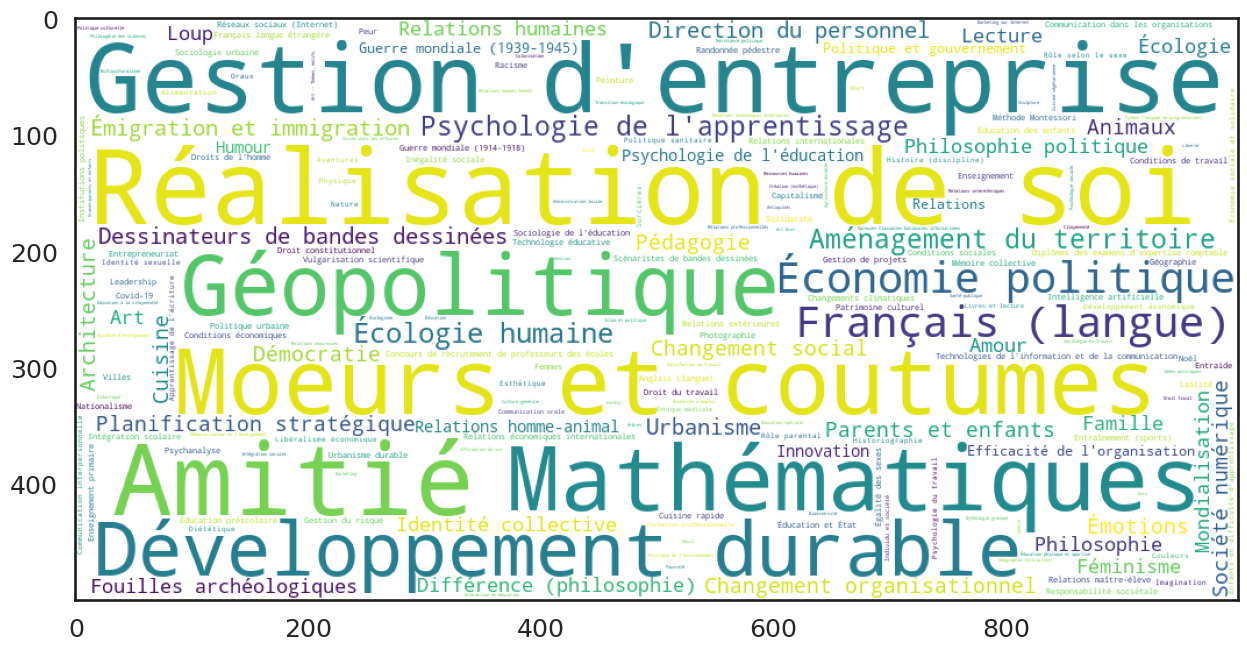

In [26]:
# Get list of chaines
plot_wordcloud(
    chaines,
    backgound_color="white",
    figsize=(15, 8),
    width=1000,
    height=500,
    save_file="wordcloud_SUDOC_chaines.png",
)

# Description des concepts

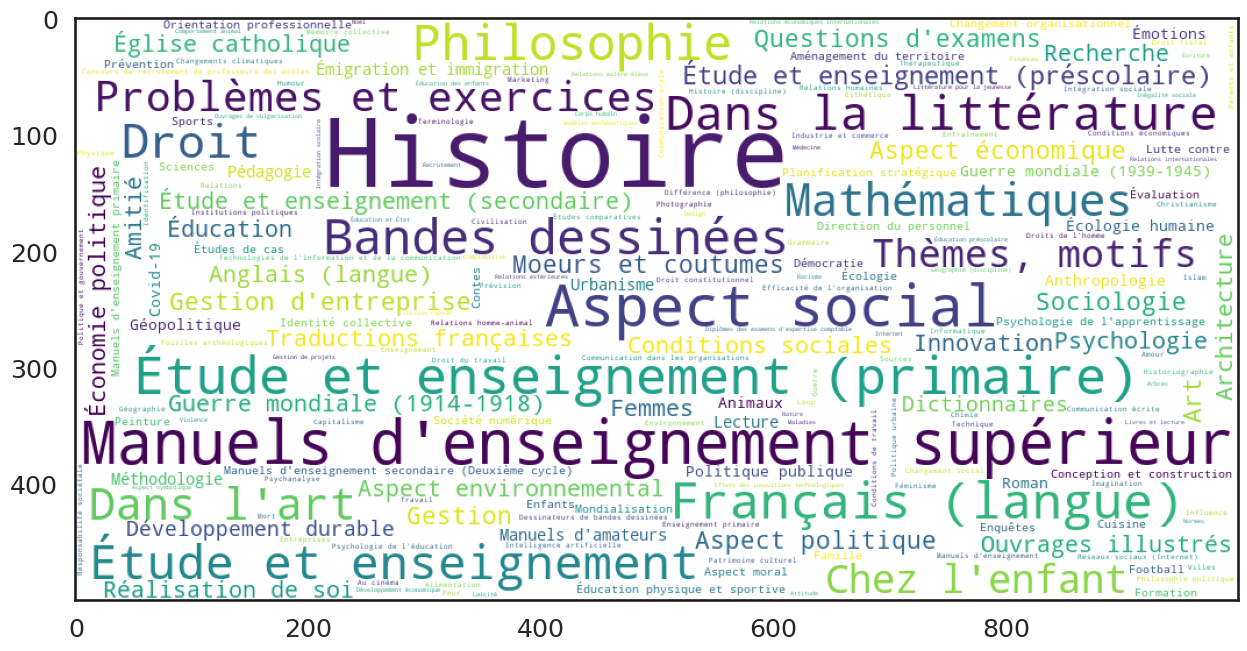

In [27]:
# Get list of labels
plot_wordcloud(
    keywords,
    backgound_color="white",
    figsize=(15, 8),
    width=1000,
    height=500,
    save_file="wordcloud_SUDOC_autorites.png",
)

In [29]:
# Verification que toutes les vedettes appartiennent au referenciel RAMEAU (nom commmuns (td) et genre/forme (tf))
RAMEAU = ram["NOM"].to_list()

if all([item in RAMEAU for item in keywords]):
    print("Tous les mots clés sont des concepts rameau")

else:
    check_ram = [item in RAMEAU for item in keywords]
    bad_keywords = []
    for i in range(len(check_ram)):
        if not check_ram[i]:
            bad_keywords.append(keywords[i])
            
    unknown_concepts = list(set(bad_keywords))
    print(f"{len(unknown_concepts)} mots clés absents du répertoire RAMEAU sur un total de {len(set(keywords))}")
    

1 mots clés absents du répertoire RAMEAU sur un total de 25717


In [30]:
unknown_concepts

['']

In [31]:
# Extract list of notices containing bad keywords
notices_with_unknwn_concepts = dict()
for kw in unknown_concepts:
    notices_with_unknwn_concepts[kw] = df.loc[df["RAMEAU_CHECKED"].str.contains(kw), "PPN"].to_list()

notices_with_unknown_concepts = pd.DataFrame(notices_with_unknwn_concepts.items(), columns=['Concepts', 'Liste des PPN des notices'])
notices_with_unknown_concepts

,Concepts,Liste des PPN des notices
0,,"[000002364, 000014877, 000021857, 00002564X, 0..."


In [32]:
df.loc[df["PPN"]== "000002364", "RAMEAU_CHECKED"].to_list()

['Culture populaire;Diffusion de la culture;Politique culturelle']

In [33]:
# Save list of badly formatted concepts, with associated SUDOC notices, for check
notices_with_unknown_concepts.to_csv(os.path.join(data_path, "concepts_a_verifier_SUDOC_file_hors_td_tf_with_associated_notices.txt"))

In [34]:
# Save list of badly formatted concepts, for check
with open(os.path.join(data_path, "concepts_a_verifier_SUDOC_file_hors_td_tf.txt"), "w") as output:
    output.write(str(unknown_concepts))
unknown_concepts

['']

# Exploration des Titres et résumés

# Exploration des titres

In [35]:
# List des stopwords
list(set(stopwords.words("french")))

['fussions',
 'avaient',
 'serait',
 'as',
 'fut',
 'sur',
 'était',
 'eusse',
 'des',
 'eusses',
 'vos',
 'me',
 'je',
 'vous',
 'nous',
 'avait',
 'y',
 'soit',
 'notre',
 'sois',
 'dans',
 'se',
 'êtes',
 'lui',
 'été',
 'avec',
 'fussiez',
 'du',
 'en',
 'elle',
 'ayante',
 'soyez',
 'eûmes',
 'eut',
 'eue',
 'il',
 'ma',
 'seriez',
 'étées',
 'tes',
 'aurez',
 'te',
 'ta',
 'fussent',
 'serai',
 'aurai',
 's',
 'une',
 'sera',
 'étiez',
 'eûtes',
 'nos',
 'aurait',
 'l',
 'serais',
 'ses',
 'sont',
 'ne',
 'm',
 'ai',
 'étions',
 'ayants',
 'de',
 'eu',
 'auront',
 'mon',
 'aurons',
 'seraient',
 'la',
 'eus',
 'avais',
 'étante',
 'serez',
 'même',
 'au',
 'j',
 'aviez',
 'aient',
 'votre',
 'étais',
 'soient',
 'mes',
 'à',
 'ont',
 'le',
 'moi',
 'pour',
 'qu',
 'toi',
 'seront',
 'ce',
 'ait',
 'un',
 'ayantes',
 'eussent',
 'serons',
 't',
 'auraient',
 'fus',
 'fûmes',
 'c',
 'auras',
 'n',
 'serions',
 'étaient',
 'es',
 'aie',
 'on',
 'ou',
 'eût',
 'étée',
 'avez',
 'fût'

In [36]:
# Test function
idx = 698
text = df.loc[idx, 'TITRE']
print(text)

Le voyage en Russie : anthologie des voyageurs français aux XVIIIe et XIXe siècles


In [37]:
# Exemple lemmatization
doc = nlp(text)
print("Sans lemmatization :", doc)

empty_list = []
for token in doc:
    empty_list.append(token.lemma_)

final_string = ' '.join(map(str,empty_list))
print("Après lemmatization :",final_string)

Sans lemmatization : Le voyage en Russie : anthologie des voyageurs français aux XVIIIe et XIXe siècles
Après lemmatization : le voyage en Russie : anthologie de voyageur français à xviii et xix siècle


In [38]:
process = PreprocessData(
    df = df,
    input_col="TITRE",
    output_col="TITRE_processed",
    add_words = [],
    numeric = False,
    stopw = True,
    stem = True,
    lem = False)

In [39]:
process.df

,PPN,TITRE,RESUME,RAMEAU,DEWEY,DESCR,RAMEAU_CHECKED,presence_chaine_indexation,rameau_chaines_index,rameau_concepts,TITRE_processed
0,000002364,La culture pour vivre,Mort de la culture populaire en France. Mutati...,Culture populaire;Diffusion de la culture;Poli...,840,La culture pour vivre Mort de la culture popul...,Culture populaire;Diffusion de la culture;Poli...,False,"[Culture populaire, Diffusion de la culture, P...","[Culture populaire, Diffusion de la culture, P...",cultur vivr
1,000014877,"La nuit, le jour : essai psychanalytique sur l...","Discontinuité, latence, rétablissement d’une c...",Complexe de castration;Psychanalyse;Rêves,154.63,"La nuit, le jour : essai psychanalytique sur l...",Complexe de castration;Psychanalyse;Rêves,False,"[Complexe de castration, Psychanalyse, Rêves]","[Complexe de castration, Psychanalyse, Rêves]",nuit jour essai psychanalyt fonction mental
2,000021857,"Ruptures, cultures","Il faut imaginer Robinson sur son île, au mome...",Culture,840,"Ruptures, cultures Il faut imaginer Robinson s...",Culture,False,[Culture],[Culture],ruptur cultur
3,00002564X,La révolution structurale,"Mutations ou crises, les brusques accès de fiè...",Structuralisme,100,"La révolution structurale Mutations ou crises,...",Structuralisme,False,[Structuralisme],[Structuralisme],révolu structural
4,000026352,La Destruction du temple,"Oswald tire sur Kennedy. Jusque-là, c'est bon,...",Science-fiction américaine -- Traductions fran...,830,La Destruction du temple Oswald tire sur Kenne...,Science-fiction américaine -- Traductions fran...,True,[Science-fiction américaine -- Traductions fra...,"[Science-fiction américaine, Traductions franç...",destruct templ
...,...,...,...,...,...,...,...,...,...,...,...
169658,26899885X,Blablabla : en finir avec le bavardage climatique,Dans le brouhaha de nos conversations et de l'...,Réchauffement de la Terre;Écologie,,Blablabla : en finir avec le bavardage climati...,Réchauffement de la Terre;Écologie,False,"[Réchauffement de la Terre, Écologie]","[Réchauffement de la Terre, Écologie]",blablabl fin bavardag climat
169659,268998884,Politique de transition écologique : Démocrati...,La transition écologique est devenue une préoc...,Aménagement du territoire;Marchés publics;Tran...,,Politique de transition écologique : Démocrati...,Aménagement du territoire;Marchés publics;Tran...,True,"[Aménagement du territoire, Marchés publics, T...","[Aménagement du territoire, Marchés publics, T...",polit transit écolog démocrat droit financ
169660,268999066,Abécédaire : mots et rites d'ailleurs,Je dédie cet abécédaire des concepts des cultu...,Ethnopsychiatrie;Psychanalyse et ésotérisme;Ri...,,Abécédaire : mots et rites d'ailleurs Je dédie...,Ethnopsychiatrie;Psychanalyse et ésotérisme;Ri...,False,"[Ethnopsychiatrie, Psychanalyse et ésotérisme,...","[Ethnopsychiatrie, Psychanalyse et ésotérisme,...",abécédair mot rit d'ailleur
169661,268999503,"Consommez moins, consommez mieux",Un cahier pratique et ludique à remplir soi-mê...,Biens de consommation durables;Consommation --...,332.024,"Consommez moins, consommez mieux Un cahier pra...",Biens de consommation durables;Consommation;Co...,False,"[Biens de consommation durables, Consommation,...","[Biens de consommation durables, Consommation,...",consomm consomm mieux


In [40]:
# add words
add_words = [
        "la",
        "de",
        "le",
        "les",
        "l",
        "au",
        "du"
]



In [41]:
process = PreprocessData(
    df = df,
    input_col="TITRE",
    output_col="TITRE_processed",
    add_words = add_words,
    encod = None,
    numeric = False,
    stopw = True,
    stem = False,
    lem = True)

In [42]:
# Get df
df = process.df

In [43]:
# Exemple
idx = 108657
print("Titre brut: \n", df['TITRE'].iloc[idx])
print("\nTitre après processing :\n", df['TITRE_processed'].iloc[idx])

Titre brut: 
 La  France en Afrique, 1520-2020 : vérités et mensonges

Titre après processing :
   france afrique 1520 - 2020 vérité mensonge


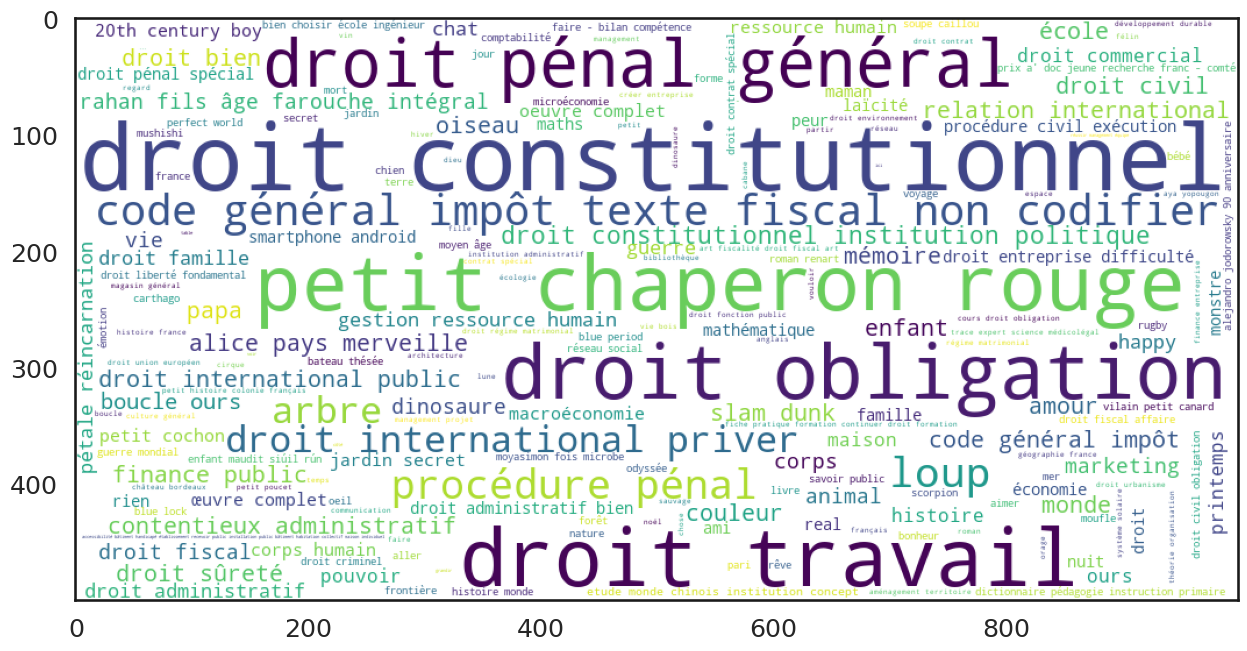

In [44]:
plot_wordcloud(df['TITRE_processed'])

## Exploration des topics (pyLDAvis)

In [45]:
# Define vectorization
vectorizer = TfidfVectorizer(
    max_features=300,
    ngram_range=(1, 5),
    min_df=10,
    max_df=0.95)

In [46]:
# Define vizualisation
n_comp = 15
lda = LatentDirichletAllocation(
    n_components=n_comp,
    learning_method='online',
    random_state=42
    )

In [47]:
# Vectorization
feature = 'TITRE_processed'
cv_transform = vectorizer.fit_transform(df[feature])
print("Dimensions de la matrice", cv_transform.shape)

Dimensions de la matrice (154508, 300)


In [48]:
# Reduction dimension
x_red = lda.fit_transform(cv_transform)

In [49]:
# Visualisation
p = pyLDAvis.sklearn.prepare(lda, cv_transform, vectorizer)
pyLDAvis.save_html(p, os.path.join(fig_path, "pyldavis_titres_lemma.html"))

AttributeError: module 'pyLDAvis' has no attribute 'sklearn'

# Exploration des résumés

In [50]:
# Preproces des résumés
process = PreprocessData(
    df = df,
    input_col="RESUME",
    output_col="RESUME_processed",
    add_words=add_words,
    numeric=False,
    stopw=True,
    stem=False,
    lem=True)

In [51]:
# Get df
df = process.df

In [52]:
# Exemple
idx = 12945
print("Résumé brut: \n", df['RESUME'].iloc[idx])
print("\nRésumé après processing :\n", df['RESUME_processed'].iloc[idx ])

Résumé brut: 
 Le premier chapitre de notre thèse présentera André Rey et son oeuvre. Nous survolerons d'abord son parcours universitaire puis ses principales conceptions de la psychologie clinique et de la testologie afin de nous familiariser avec l'homme. Nous aborderons ensuite ses travaux dans les domaines de la psychologie animale et humaine, dans le domaine de la psychométrie et dans le domaine de la psychologie appliquée à l'éducation. La présentation de ces travaux constituera une introduction à son examen du fonctionnement intellectuel. Le modèle d'évaluation du fonctionnement cognitif fera l'objet du second chapitre. Nous y consacrerons un effort tout particulier dans la mesure où il est moins connu que celui de Feuerstein. Nous présenterons les objectifs de ce modèle, la recherche des réactions suspectes comme déterminismes de la performance, la conduite de l'examen et des épreuves proposées, l'interprétation et enfin le diagnostic. L'interprétation retiendra toute notre att

In [53]:
# Vectorization
feature = 'RESUME_processed'
cv_transform = vectorizer.fit_transform(df[feature])
print("Dimensions de la matrice", cv_transform.shape)

Dimensions de la matrice (154508, 300)


In [54]:
# Reduction dimension
x_red = lda.fit_transform(cv_transform)

In [ ]:
# Vizualisation
p = pyLDAvis.sklearn.prepare(lda, cv_transform, vectorizer)
pyLDAvis.save_html(p, os.path.join(fig_path, "pyldavis_resumes_lemma.html"))

# Exploration des description (titre+ resumé)

In [55]:
# Preproces des descriptions
process = PreprocessData(
    df = df,
    input_col="DESCR",
    output_col="DESCR_processed",
    add_words=add_words,
    numeric=False,
    stopw=True,
    stem=False,
    lem=True)

In [56]:
# Get df
df = process.df

In [57]:
df.to_pickle(os.path.join(data_path, "working_data_sans_dewey_processed.pkl"))

In [58]:
# Exemple
idx = 6549
print("Description brute: \n", df['DESCR'].iloc[idx])
print("\nDescription après processing :\n", df['DESCR_processed'].iloc[idx])

Description brute: 
 Pertinences en éducation Le premier tome répondait à quelques questions récurrentes en éducation, le deuxième répond en termes de pratiques à développer. Rassemble des textes publiés pour la plupart dans "Animation et éducation".

Description après processing :
 pertinence éducation tome répondre question récurrent éducation répondre terme pratique développer rassembler texte publier plupart " animation éducation "


In [59]:
# Define vectorization
vectorizer = TfidfVectorizer(
    max_features=300,
    ngram_range=(1, 5),
    min_df=10,
    max_df=0.95)

In [60]:
# Vectorization
feature = 'DESCR_processed'
cv_transform = vectorizer.fit_transform(df[feature])
print("Dimensions de la matrice", cv_transform.shape)

Dimensions de la matrice (154508, 300)


In [61]:
# Reduction dimension
x_red = lda.fit_transform(cv_transform)

In [ ]:
# Vizualisation
p = pyLDAvis.sklearn.prepare(lda, cv_transform, vectorizer)
pyLDAvis.save_html(p, os.path.join(fig_path, "pyldavis_description_lemma.html"))

In [62]:
# Représentation TSNE des descriptions
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, random_state=123, init="random")
vectorised_documents = tsne.fit_transform(cv_transform)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 154508 samples in 0.004s...
[t-SNE] Computed neighbors for 154508 samples in 740.154s...
[t-SNE] Computed conditional probabilities for sample 1000 / 154508
[t-SNE] Computed conditional probabilities for sample 2000 / 154508
[t-SNE] Computed conditional probabilities for sample 3000 / 154508
[t-SNE] Computed conditional probabilities for sample 4000 / 154508
[t-SNE] Computed conditional probabilities for sample 5000 / 154508
[t-SNE] Computed conditional probabilities for sample 6000 / 154508
[t-SNE] Computed conditional probabilities for sample 7000 / 154508
[t-SNE] Computed conditional probabilities for sample 8000 / 154508
[t-SNE] Computed conditional probabilities for sample 9000 / 154508
[t-SNE] Computed conditional probabilities for sample 10000 / 154508
[t-SNE] Computed conditional probabilities for sample 11000 / 154508
[t-SNE] Computed conditional probabilities for sample 12000 / 154508
[t-SNE] Computed conditional proba

In [63]:
# Build dataframe
tsne_df = pd.DataFrame()
tsne_df["comp-1"] = vectorised_documents[:,0]
tsne_df["comp-2"] = vectorised_documents[:,1]

/tmp/ipykernel_1471560/902094180.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="comp-1", y="comp-2",


[Text(0.5, 1.0, 'Notice description T-SNE projection')]

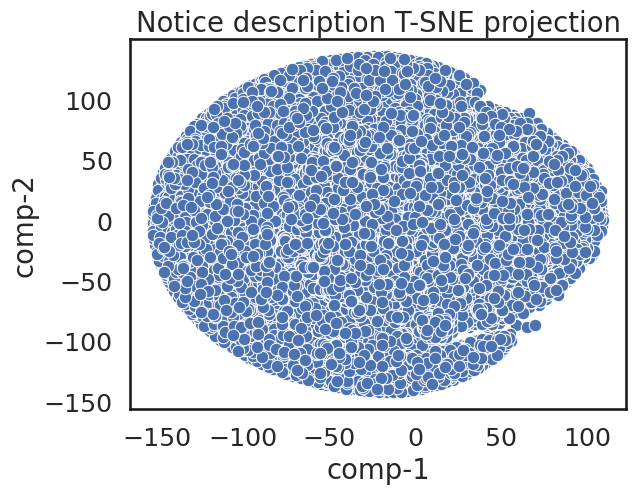

In [64]:
# Plot TSNE result
sns.scatterplot(x="comp-1", y="comp-2", 
                palette=sns.color_palette("hls", 25),
                data=tsne_df).set(title="Notice description T-SNE projection") 